**Memoizing** is the process of storing the results of a function so that the next time the function is called with the same arguments

We start by setting up a dictionary that will map arguments to results. Then, as usual, we create wrapper() to be the new decorated function that this decorator returns.

In [1]:
def memoize(func):
    """Store the results of the decorated function for fast lookup
    """

    # Store results in a dict that maps arguments to results
    cache = {}

    def wrapper(a,b):
        # If these arguments haven't been seen before, call func() and store the result.
        if (a, b) not in cache:        
            cache[(a,b)] = func(a,b)          
        return cache[(a, b)]

    return wrapper

Here we are memoizing slow_function(). slow_function() simply returns the sum of its arguments. In order to simulate a slow function, we have it sleep for 5 seconds before returning.

In [2]:
import time

@memoize
def slow_function(a, b):
    print('Sleeping...')
    time.sleep(5)
    return a + b

In [3]:
slow_function(3, 4)

Sleeping...


7

If we call slow_function() with the arguments 3 and 4 again, it will immediately return 7.

In [4]:
slow_function(3, 4)

7

Because we've stored the answer in the cache, the decorated function doesn't even have to call the original slow_function() function.

We're working on a project, and we are curious about how many times each of the functions in it gets called. So we decide to write a decorator that adds a counter to each function that we decorate. We could use this information in the future to determine whether there are sections of code that we could remove because they are no longer being used.

In [5]:
def counter(func):
    def wrapper(*args, **kwargs):
        wrapper.count += 1
        # Call the function being decorated and return the result
        return func(*args, **kwargs)
    wrapper.count = 0
    # Return the new decorated function
    return wrapper

# Decorate foo() with the counter() decorator
@counter
def foo():
    print('calling foo()')

foo()
foo()

print('foo() was called {} times.'.format(foo.count))

calling foo()
calling foo()
foo() was called 2 times.


Let's look at another example of a real world decorator.

The timer() decorator runs the decorated function and then prints how long it took for the function to run. It's good to add some version of this to all of our projects because it is a pretty easy way to figure out where our computational bottlenecks are.

Like most decorators, we'll start off by defining a wrapper() function. This is the function that the decorator will return. wrapper() takes any number of positional and keyword arguments, so that it can be used to decorate any function.

In [26]:
def timer(func):
    """A decorator that prints how long a function took to run."""

    # Define the wrapper function to return.
    def wrapper(*args, **kwargs):
        # When wrapper() is called, get the current time.
        t_start = time.time()

        # Call the decorated function and store the result.
        result = func(*args, **kwargs)

        # Get the total time it took to run, and print it.
        t_total = time.time() - t_start

        print('{} took {}s'.format(func.__name__, t_total))        
        return result

    return wrapper

In [27]:
@timer
def sleep_n_seconds(n):
    time.sleep(n)
    
sleep_n_seconds(5)

sleep_n_seconds took 5.008584260940552s


In [28]:
def print_return_type(func):
    # Define wrapper(), the decorated function
    def wrapper(*args, **kwargs):
        # Call the function being decorated
        result = func(*args, **kwargs)
        print('{}() returned type {}'.format(
        func.__name__, type(result)
        ))
        return result
    # Return the decorated function
    return wrapper

In [29]:
@print_return_type
def foo(value):
     return value

In [30]:
print(foo(42))
print(foo([1, 2, 3]))
print(foo({'a': 42}))

foo() returned type <class 'int'>
42
foo() returned type <class 'list'>
[1, 2, 3]
foo() returned type <class 'dict'>
{'a': 42}


One of the problems with decorators is that they obscure the decorated function's metadata.

In [32]:
def sleep_n_seconds(n=10):
    """Pause processing for n seconds.

    Args:
        n (int): The number of seconds to pause for.
    """
    time.sleep(n)

In [34]:
print(sleep_n_seconds.__doc__)
print()
print(sleep_n_seconds.__name__)
print()
print(sleep_n_seconds.__defaults__)

Pause processing for n seconds.

    Args:
        n (int): The number of seconds to pause for.
    

sleep_n_seconds

(10,)


In [6]:
def timer(func):
    """A decorator that prints how long a function took to run."""  
    def wrapper(*args, **kwargs):
        t_start = time.time()
    
        result = func(*args, **kwargs)
    
        t_total = time.time() - t_start
        print('{} took {}s'.format(func.__name__, t_total))
    
        return result
    return wrapper

@timer
def sleep_n_seconds(n=10):
    """Pause processing for n seconds.
  
    Args:
        n (int): The number of seconds to pause for.
    """
    time.sleep(n)
print(sleep_n_seconds.__doc__)
print(sleep_n_seconds.__name__)

None
wrapper


We saw that when we try to print the docstring for sleep_n_seconds(), we get nothing back. Even stranger, if we try to look up the function's name, Python tells us that sleep_n_seconds()'s name is "wrapper".

To understand why, we have to examine the timer() decorator. Remember that when we write decorators we almost always define a nested function to return. Because the decorator overwrites the sleep_n_seconds() function, when we ask for sleep_n_seconds()'s docstring or name, we are actually referencing the nested function that was returned by the decorator. In this case, the nested function was called wrapper() and it didn't have a docstring.

Fortunately, Python provides us with an easy way to fix this. The wraps() [function](https://docs.python.org/3.7/library/functools.html#functools.wraps) from the functools [module](https://docs.python.org/3.7/library/functools.html) is a decorator that we use when defining a decorator. If we use it to decorate the wrapper function that our decorator returns, it will modify wrapper()'s metadata to look like the function we are decorating.

In [39]:
from functools import wraps

def timer(func):
    """A decorator that prints how long a function took to run."""

    @wraps(func)
    def wrapper(*args, **kwargs):
        t_start = time.time()
    
        result = func(*args, **kwargs)
    
        t_total = time.time() - t_start
        print('{} took {}s'.format(func.__name__, t_total))
    
        return result
    return wrapper

In [40]:
@timer
def sleep_n_seconds(n=10):
    """Pause processing for n seconds.

    Args:
        n (int): The number of seconds to pause for.
    """
    time.sleep(n)

In [41]:
print(sleep_n_seconds.__doc__)

Pause processing for n seconds.

    Args:
        n (int): The number of seconds to pause for.
    


Likewise, printing the name or any other metadata now gives us the metadata from the function being decorated rather than the metadata of the wrapper() function.

As an added bonus, using wraps() when creating our decorator also gives us easy access to the original undecorated function via the '__' wrapped '__' attribute. Of course, we always had access to this function via the closure, but this is an easy way to get to it if we need it.

In [42]:
sleep_n_seconds.__wrapped__

<function __main__.sleep_n_seconds(n=10)>

In [43]:
from functools import wraps
def add_hello(func):
    # Decorate wrapper() so that it keeps func()'s metadata
    @wraps(func)
    def wrapper(*args, **kwargs):
        """Print 'hello' and then call the decorated function."""
        print('Hello')
        return func(*args, **kwargs)
    return wrapper

@add_hello
def print_sum(a, b):
    """Adds two numbers and prints the sum"""
    print(a + b)

print_sum(10, 20)
print(print_sum.__doc__)

Hello
30
Adds two numbers and prints the sum


Sometimes it would be nice to add arguments to our decorators. To do that, we need another level of nesting in our decorators.

In [1]:
def run_three_times(func):
    def wrapper(*args, **kwargs):
        for _ in range(3):
            func(*args, **kwargs)
    return wrapper

In [2]:
@run_three_times
def print_sum(a, b):
    print(a + b)


In [3]:
print_sum(3, 5)

8
8
8


Let's think about what we would need to change if we wanted to write a run_n_times() decorator. We want to pass n in as an argument, instead of hard-coding in the decorator.

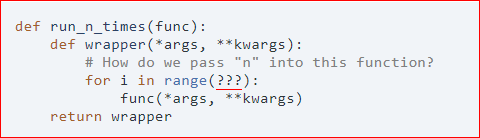

If we had some way to pass n into the decorator, we could decorate print_sum() so that it gets run three times and decorate the print_hello() function to run five times.

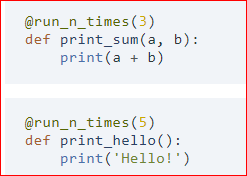

But a decorator is only supposed to take one argument - the function it is decorating. Also, when we use decorator syntax, we're not supposed to use the parentheses. So how can this be done?

To make run_n_times() work, we have to turn it into a function that returns a decorator, rather than a function that is a decorator.

We'll start by redefining run_n_times() so that it takes n as an argument, instead of func. Then, inside of run_n_times(), we'll define a new decorator function. This function takes func as an argument, because it is the function that will be acting as our decorator.

In [7]:
def run_n_times(n):
    """Define and return a decorator"""
    def decorator(func):
        def wrapper(*args, **kwargs):
            for i in range(n):
                func(*args, **kwargs)
        return wrapper
    return decorator

As usual for any decorator, we return the new wrapper() function. And, if run_n_times() returns the decorator() function we just defined, then we can use that return value as a decorator.

In [8]:
@run_n_times(5)
def print_sum(a, b):
    print(a + b)

In [9]:
print_sum(3, 5)

8
8
8
8
8


This indicates that we are actually calling run_n_times() and decorating print_sum() with the result of that function call. Since the return value from run_n_times() is a decorator function, we can use it to decorate print_sum().

We could decorate print_sum() with this new decorator using decorator syntax.

Python makes it convenient to do both of those in a single step though. When we use decorator syntax, the thing that comes after the @ symbol must be a reference to a decorator function. We can use the name of a specific decorator, or we can call a function that returns a decorator.

In [10]:
@run_n_times(3)
def print_sum(a, b):
    print(a + b)

print_sum(3, 5)

@run_n_times(5)
def print_hello():
    print('Hello!')

print_hello()

8
8
8
Hello!
Hello!
Hello!
Hello!
Hello!


let's imagine that we have some functions that occasionally either run for longer than we want them to, or just hang and never return.

It would be nice if we could add some kind of timeout() decorator to those functions that will raise an error if the function runs for longer than expected.

To create the timeout() decorator, we are going to use some functions from Python's signal [module](https://docs.python.org/3/library/signal.html). These functions have nothing to do with decorators, but understanding them will help us understand the timeout() decorator.

The raise_timeout() function simply raises a TimeoutError when it is called.

In [11]:
import signal

def raise_timeout(*args, **kwargs):
    raise TimeoutError()

The signal() function tells Python, "When you see the signal whose number is signalnum, call the handler function." In this case, we tell Python to call raise_timeout() whenever it sees the alarm signal.

In [15]:
# When an "alarm" signal goes off, call raise_timeout()
signal.signal(signalnum=2, handler=raise_timeout)

<function _signal.default_int_handler>

The alarm() function lets us set an alarm for some number of seconds in the future.

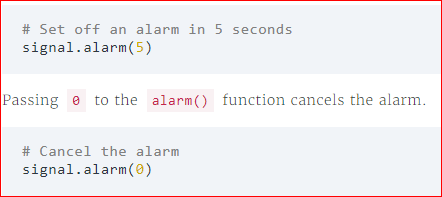

We'll start by creating a decorator that times out in exactly 5 seconds, and then build from there to create a decorator that takes the timeout length as an argument.

Our timeout_in_5s() decorator starts off by defining a wrapper() function to return as the new decorated function. Returning this function is what makes timeout_in_5s() a decorator.

In [122]:
import signal
def timeout_in_5s(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Set an alarm for 5 seconds
        signal.alarm(5)
        try:
            # Call the decorated func
            return func(*args, **kwargs)
        finally:
            # Cancel alarm
            signal.alarm(0)
    return wrapper

First wrapper() sets an alarm for 5 seconds in the future.

Then it calls the function being decorated. It wraps that call in a try block so that in a finally block we can cancel the alarm. This ensures that the alarm either rings or gets canceled. Remember, when the alarm rings, Python calls the raise_timeout() function.

In [123]:
@timeout_in_5s
def foo():
    time.sleep(10)
    print('foo!')

If we call foo(), the 5 second alarm will ring before it finishes sleeping, and Python will raise a TimeoutErrror.

In [ ]:
foo()

In [83]:
def timeout(n_seconds):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            # Set an alarm for n seconds
            signal.alarm(n_seconds)
            try:
               # Call the decorated func
               return func(*args, **kwargs)
            finally:
               # Cancel alarm
               signal.alarm(0)
        return wrapper
    return decorator

@timeout(20)
def bar():
    time.sleep(10)
    print('bar!')
bar()

bar!


We created a more useful version of the timeout() decorator. This decorator takes an argument that allows us to set a timeout that is appropriate for each function.

Notice that wrapper() returns the result of calling func(), decorator() returns wrapper, and timeout() returns decorator.

timeout() is now a function that returns a decorator. We can think of it as a decorator factory. When we call timeout(), it cranks out a brand new decorator that times out in 5 seconds, or 20 seconds, or whatever value we pass as n_seconds.

So when we called bar(), which has a 20-second timeout, it printed its message in 10 seconds, so the alarm got canceled.

However, if we called foo() instead, which has a 5-second timeout, it will timeout.

In [ ]:
@timeout(5)
def foo():
    time.sleep(10)
    print('foo!')

foo()

In [66]:
def tag(*tags):
    # Define a new decorator, named decorator(), to return
    def decorator(func):
        # Ensure the decorated function keeps its metadata
        @wraps(func)
        def wrapper(*args, **kwargs):
            # Call the function being decorated and return the result
            return func(*args, **kwargs)
        wrapper.tags = tags
        return wrapper
    # Return the new decorator
    return decorator

@tag('test', 'this is a tag')
def foo():
    pass

print(foo.tags)

('test', 'this is a tag')
